### The synthetic universe framework

This project includes a **synthetic market simulation framework** designed with two main goals in mind:

1. **Overcoming data limitations**: real market data is often expensive, restricted, or incomplete.
2. **Testing in controlled environments**: synthetic universes allow you to evaluate strategies and hypotheses against a known and configurable market structure.

In this notebook, I’ll walk you through how to use the simulation framework so you can **generate your own custom universes** quickly and flexibly.

## The `UniverseSpec` dataclass

A universe is defined through the `UniverseSpec` dataclass, which follows the schema:

```python
UniverseSpec(
    key: str
    cls: str
    sector: str
    name: str
    simulator: Callable[..., tuple[pd.DataFrame, dict[str, object]]]
    n_tickers: int
    sim_params: Mapping[str, object] = field(default_factory=dict)
    meta: dict[str, object] = None
)
```

- `key`, `cls`, and `sector` are descriptive attributes used for organizational and labeling purposes.
- `name` is a display label used in plots or reports.
- `simulator` specifies the simulation routine to be used (e.g., GBM).
- `n_tickers` defines how many tickers the universe will contain.
- `sim_params` holds all parameters required by the selected simulator.
- `meta` is initially empty and will be populated with metadata after the simulation is executed.

For an overview of all available simulation routines and their required parameters, see [not available yet, currently only GBM is available].


## Simulating a universe

To simulate a universe, you need to specify the time horizon either as a `pd.DatetimeIndex` or via two strings `start` and `end` in the format `'YYYY-MM-DD'`.

Once defined, you can generate the universe with:

```python
px, meta = simulate_universe(
    univ=my_universe,
    start=start,
    end=end
)
```

- `px` is a `pd.DataFrame` containing the time evolution of all tickers.
- `meta` contains additional metadata recorded during the simulation.

The resulting universe can then be plotted, analyzed, or used as input for downstream applications such as strategy evaluation.

The example below demonstrates this workflow step by step.

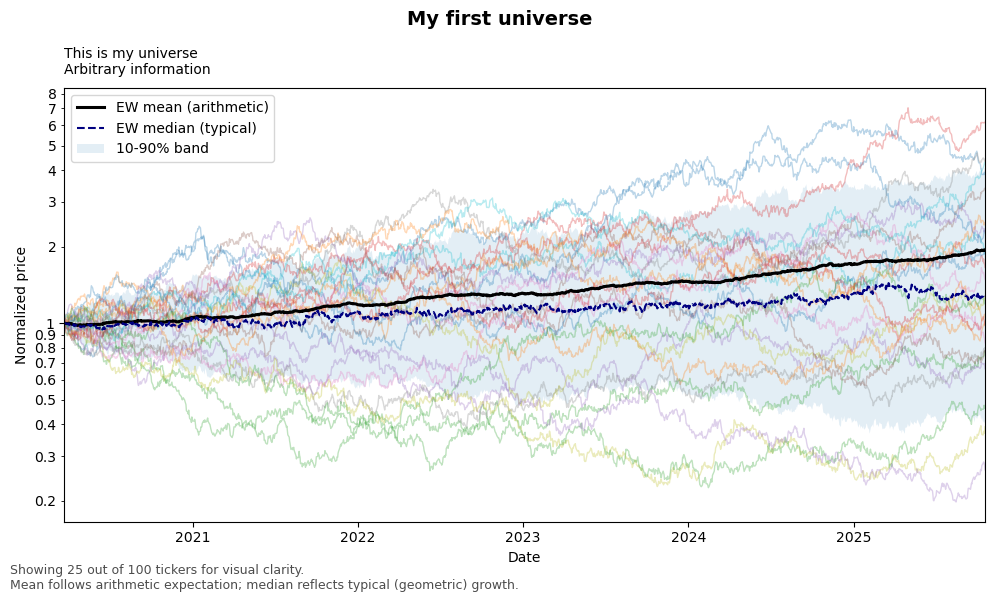

In [1]:
# import the dataclass
from mlbt.specs.universe_spec import UniverseSpec

# import the simulator routine
from mlbt.simulator.simulators import simulate_gbm_trajectories

# define the simulation parameters
gbm_params = {
    "mu": [0.10],
    "sigma": [0.35]
}

# create your universe specification
my_universe = UniverseSpec(
    key="my_univ",
    cls="GBM equities",
    sector="Technology",
    name="Tech100",
    simulator=simulate_gbm_trajectories,
    n_tickers=100,
    sim_params=gbm_params
)

# optional: seed a random number generator
import numpy as np
rng = np.random.default_rng(seed=1234567890)

# import the simulation runner and generate the universe
start = "2020-03-23"
end = "2025-10-17"
from mlbt.simulator.simulators import simulate_universe
px, meta = simulate_universe(
    univ=my_universe,
    start=start,
    end=end,
    rng=rng
)

# plot the resulting universe
from mlbt.visualisation import plot_universe
_ = plot_universe(
    px=px,
    univ=my_universe,
    title="My first universe",
    subtitle="This is my universe\nArbitrary information",
    n_samples=25
)

## Including paradigm shifts

The `UniverseSpec` class supports paradigm shifts, allowing you to model different market cycles or regimes within a single simulation.

How paradigm shifts are handled depends on the chosen simulator routine. In most cases, however, this only requires:

- A list of parameter sets in `sim_params` — one for each phase, and
- An additional field `switch_at` containing floats in [0, 1] that define when (relative to the total simulation horizon) each shift occurs.

Optionally, you can also include labels to name the different phases.
Currently, these inputs are not guarded — make sure to provide valid and sensible values.

### Example: Including paradigm shifts

Below is an example that illustrates how to define and simulate a GBM universe with multiple market regimes using the `switch_at` mechanism.

We first specify a set of parameters for each regime. Here, we use different combinations of drift ($\mu$) and volatility ($\sigma$), along with the relative time points at which the regime shifts occur. Labels are optional but helpful for visualization.

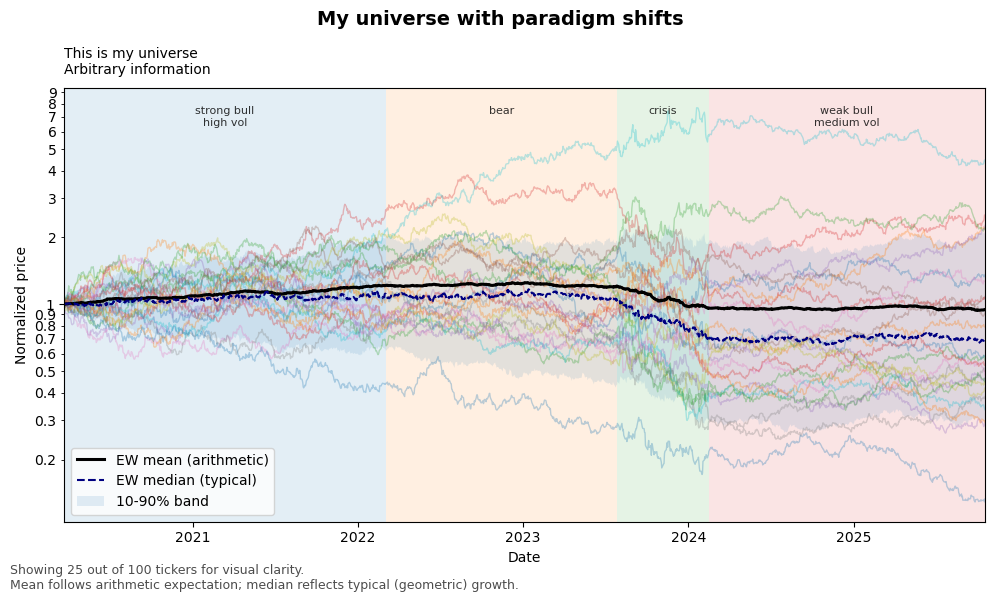

In [2]:
# define multiple paradigms
paradigm_params = {
    "mu": [0.10, -0.03, -0.5, 0.05],
    "sigma": [0.35, 0.3, 0.6, 0.25],
    "switch_at": [0.35, 0.6, 0.7],
    "labels": ["strong bull\nhigh vol", "bear", "crisis", "weak bull\nmedium vol"]
}

# we can even reuse the previous universe using replace
from dataclasses import replace
my_paradigm_universe = replace(
    my_universe,
    key="my_new_univ",
    sim_params=paradigm_params
)

# generate and plot again
px, meta = simulate_universe(
    univ=my_paradigm_universe,
    start=start,
    end=end,
    rng=rng
)
_ = plot_universe(
    px=px,
    univ=my_paradigm_universe,
    title="My universe with paradigm shifts",
    subtitle="This is my universe\nArbitrary information",
    n_samples=25
)

## Mixing universes

The simulation framework doesn’t (yet) natively support composing multiple sub-universes into a single universe. However, this can easily be done manually with a small loop.

To plot a mixed universe, simply omit the `univ` argument when calling `plot_universe`.

### Example: Mixing universes

Below is a minimal example showing how to combine multiple sub-universes into a single mixed universe.

Each sub-universe is simulated separately with its own RNG. The `UniverseSpec.key` attribute automatically handles prefixing, so ticker names remain unique. Since all universes are simulated over the same `start` and `end` dates, the resulting price tables align naturally.

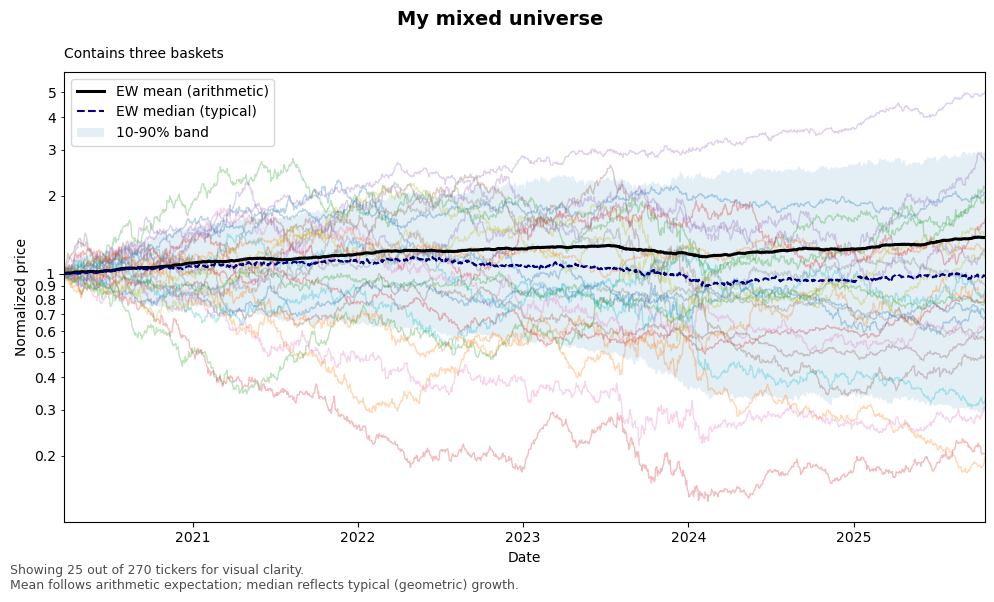

In [3]:
# create a second universe
universe2_params = {
    "mu": [0.05, -0.01, 0.04],
    "sigma": [0.2, 0.2, 0.15],
    "switch_at": [0.35, 0.7],
    "labels": ["weak bull", "weak bear", "weak bull"]
}
my_universe2 = UniverseSpec(
    key="my_univ2",
    cls="GBM equities",
    sector="Value",
    name="Value70",
    simulator=simulate_gbm_trajectories,
    n_tickers=70,
    sim_params=universe2_params
)

# collect all universes
univ_registry = [my_universe, my_paradigm_universe, my_universe2]

# different RNGs for all universes
master_seed = 1234567890
ss_master = np.random.SeedSequence(master_seed)
ss_run = ss_master.spawn(len(univ_registry))

pxs = []
for i, u in enumerate(univ_registry):
    rng = np.random.default_rng(ss_run[i])
    px, meta = simulate_universe(
        univ=u,
        start=start,
        end=end,
        rng=rng
    )
    pxs.append(px)

# now join all universes and plot
import pandas as pd
px_mixed = pd.concat(pxs, axis=1)
_ = plot_universe(
    px=px_mixed,
    title="My mixed universe",
    subtitle="Contains three baskets",
    n_samples=25
)
